# DSL Project 2020: classification on tweet sentiment

### Import Libraries

In [36]:
# Numeric
import numpy as np
import pandas as pd


# Tools
import os, sys
import re
import string
import csv
import itertools
import nltk


# Natural language processing
# from nltk.tokenize import word_tokenize
# from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
# from nltk.corpus import stopwords as sw
# from nltk.stem.snowball import SnowballStemmer


# Preprocessing and Features engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2


# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import NearestNeighbors

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

flag_tuning = True

## Data exploration

In [37]:
dir_path = "DSL2122_january_dataset/"
dev_dataset = pd.read_csv(dir_path + "development.csv")
eval_dataset = pd.read_csv(dir_path + "evaluation.csv")

print(dev_dataset.iloc[:,0].size)
dev_dataset.head()

224994


,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [38]:
dev_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


In [39]:
print(f"Development dataset size: {dev_dataset['text'].size}")
print(f"Evaluation dataset size: {eval_dataset['text'].size}")

Development dataset size: 224994
Evaluation dataset size: 74999


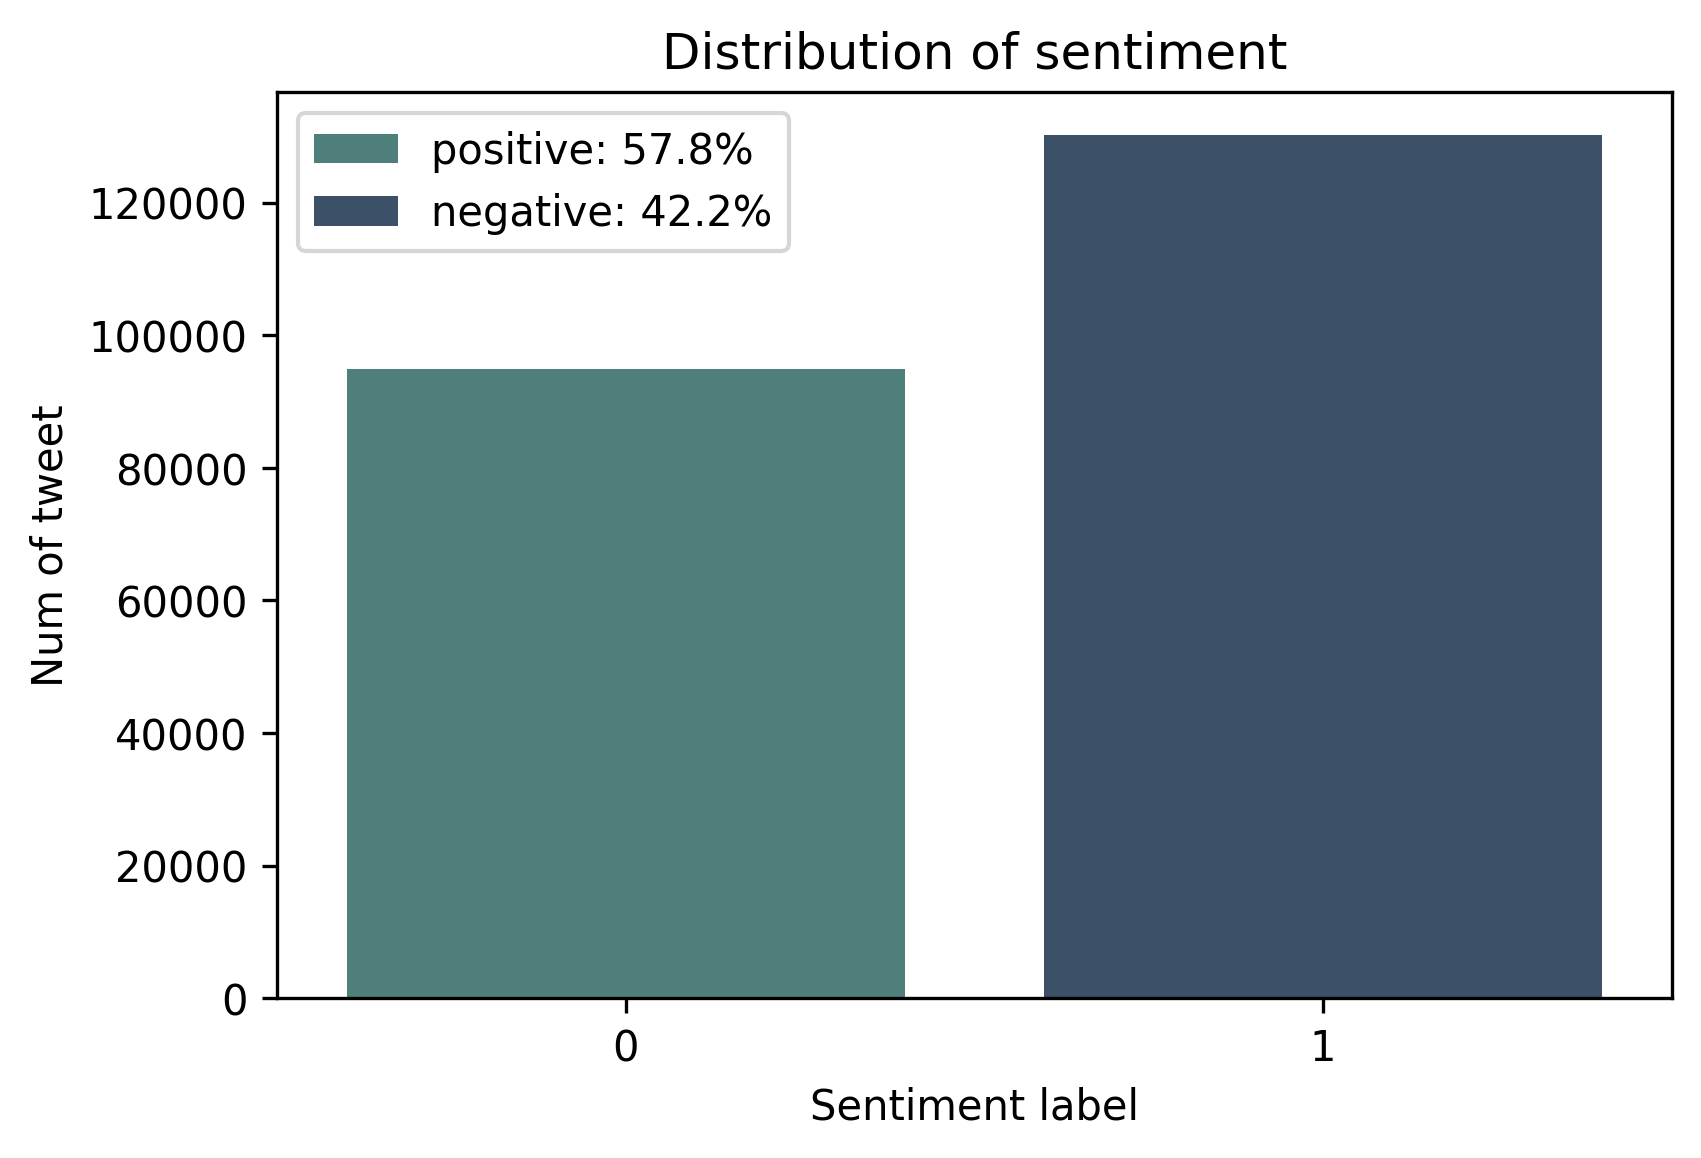

In [40]:
# compute distribution percentages
pos_perc = 100 * dev_dataset[dev_dataset['sentiment'] == 1].size / dev_dataset.size
neg_perc = 100 - pos_perc

fig, ax = plt.subplots(dpi=300)
ax = sns.countplot(x = 'sentiment', data = dev_dataset,
              palette = sns.cubehelix_palette(2, start=.4, rot=-.75, light=.45, dark=.3))
ax.set_ylabel('Num of tweet')
ax.set_xlabel('Sentiment label')
ax.set_title('Distribution of sentiment')
ax.legend(handles=ax.patches, labels=(f'positive: {pos_perc:.1f}%', f'negative: {neg_perc:.1f}%'))
plt.savefig('DistributionOfSentiment.svg', bbox_inches="tight")
plt.show()

## Preprocessing dataset

In [41]:
#How many nan values are there? zero
dev_dataset.isnull().any()

sentiment    False
ids          False
date         False
flag         False
user         False
text         False
dtype: bool

In [42]:
ds = dev_dataset.copy()
# how many tweet ids are duplicates? around 200
ds.drop_duplicates(['ids'],inplace=True)
print(ds.iloc[:,0].size)

224716


In [43]:
ds = dev_dataset.copy()
# how many user are there? around 10000
ds.drop_duplicates(['user'],inplace=True)
print(ds.iloc[:,0].size)

10647


In [44]:
ds = dev_dataset.copy()
# how many copies of tweet text are there? around 1500
ds.drop_duplicates(['text'],inplace=True)
print(ds.iloc[:,0].size)

223106


In [45]:
# create a new text_bis column in case of text processing

dev_dataset['text_bis'] = dev_dataset.apply(lambda row: row.text, axis = 1)
df_done = dev_dataset.drop(columns=["flag", "ids", "date"])

eval_dataset['text_bis'] = eval_dataset.apply(lambda row: row.text, axis = 1)
df_eval_done = eval_dataset.drop(columns=["flag", "ids", "date"])

df_done.head()

,sentiment,user,text,text_bis
0,1,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...","@MissBianca76 Yes, talking helps a lot.. going..."
1,1,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,yaseminx3,@PleaseBeMine Something for your iphone,@PleaseBeMine Something for your iphone
3,0,no_surprises,@GabrielSaporta couldn't get in to the after p...,@GabrielSaporta couldn't get in to the after p...
4,0,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,@bradiewebbstack awww is andy being mean again...


##  Text preprocessing
Remove or transform particular word or meaningless word like emoji

In [46]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

def preprocess(textdata):
    processedText = []
    
#     # Create Lemmatizer and Stemmer.
#     wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        #tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        #tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

#         tweetwords = ''
#         for word in tweet.split():
#             # Checking if the word is a stopword.
#             #if word not in stopwordlist:
#             if len(word)>1:
#                 # Lemmatizing the word.
#                 word = wordLemm.lemmatize(word)
#                 tweetwords += (word+' ')
            
        processedText.append(tweet)
        
    return processedText

# https://www.kaggle.com/redaabdou/depression-on-social-media
def clean_text_tweet_for_tfidfVect(data):
    
    data['text'] = data['text'].str.replace("@", "") #Removing Twitter Handles (@user)
    data['text'] = data['text'].str.replace(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", "") #Removing links
    data['text'] = data['text'].str.replace("[^a-zA-Z0-9]", " ") #Removing Punctuations, Numbers, and Special Characters
    data['text'] = data['text'].str.replace(r"(.)\1\1+", r"\1\1") # Replace 3 or more consecutive letters by 2 letter.
    
#     #Text Tokenization and Normalization
#     data['text'] = data['text'].apply(lambda x: x.split())
#     stemmer = PorterStemmer() 
#     data['text'] = data['text'].apply(lambda x: [stemmer.stem(i) for i in x])
#     data['text'] = data['text'].apply(lambda x: ' '.join([w for w in x]))
    
#     data['text'] = data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #Removing small words
    
    #emoji transformation in word
    for tweet in list(data['text']):
        tweet = tweet.lower()
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, emojis[emoji])

    return data

def clean_text_tweet_for_countVect(data):
    
    data['text_bis'] = data['text_bis'].str.replace("@", "") #Removing Twitter Handles (@user)
    data['text_bis'] = data['text_bis'].str.replace(r"http\S+", "") #Removing links
    data['text_bis'] = data['text_bis'].str.replace("[^a-zA-Z0-9]", " ") #Removing Punctuations, Numbers, and Special Characters
    
    stopwords=nltk.corpus.stopwords.words('english')
    data['text_bis'] = data['text_bis'].apply(lambda text : ' '.join([word for word in text.lower().split() if word not in stopwords]))
    
    #Text Tokenization and Normalization
    data['text_bis'] = data['text_bis'].apply(lambda x: x.split())
    stemmer = PorterStemmer() 
    data['text_bis'] = data['text_bis'].apply(lambda x: [stemmer.stem(i) for i in x])
    data['text_bis'] = data['text_bis'].apply(lambda x: ' '.join([w for w in x]))
    
    data['text_bis'] = data['text_bis'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) #Removing small words
    
    #emoji transformation in word
    for tweet in list(data['text_bis']):
        tweet = tweet.lower()
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, emojis[emoji])
    return data

In [47]:

import time
t = time.time()

df_done = clean_text_tweet_for_tfidfVect(df_done)
df_done = clean_text_tweet_for_countVect(df_done)

df_eval_done = clean_text_tweet_for_tfidfVect(df_eval_done)
df_eval_done = clean_text_tweet_for_countVect(df_eval_done)

print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

df_done.head()

/tmp/ipykernel_118732/4139672355.py:73: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", "") #Removing links
/tmp/ipykernel_118732/4139672355.py:74: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace("[^a-zA-Z0-9]", " ") #Removing Punctuations, Numbers, and Special Characters
/tmp/ipykernel_118732/4139672355.py:75: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace(r"(.)\1\1+", r"\1\1") # Replace 3 or more consecutive letters by 2 letter.
/tmp/ipykernel_118732/4139672355.py:96: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text_bis'] = data['text_bis'].str.replace(r"http\S+", "") #Removing links
/tmp/ipykernel_118732/4139672355.

Text Preprocessing complete.
Time Taken: 42 seconds


,sentiment,user,text,text_bis
0,1,Killandra,MissBianca76 Yes talking helps a lot going t...,missbianca76 talk help judgment sentenc quot k...
1,1,IMlisacowan,SUNSHINE livingg itt imma lie on the grass l...,sunshin livingg itttt imma grass listen oasi r...
2,1,yaseminx3,PleaseBeMine Something for your iphone,pleasebemin someth iphon
3,0,no_surprises,GabrielSaporta couldn t get in to the after pa...,gabrielsaporta parti
4,0,Rhi_ShortStack,bradiewebbstack aww is andy being mean again ...,bradiewebbstack awww andi mean want macca


In [48]:
df_done.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   user       224994 non-null  object
 2   text       224994 non-null  object
 3   text_bis   224994 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.9+ MB


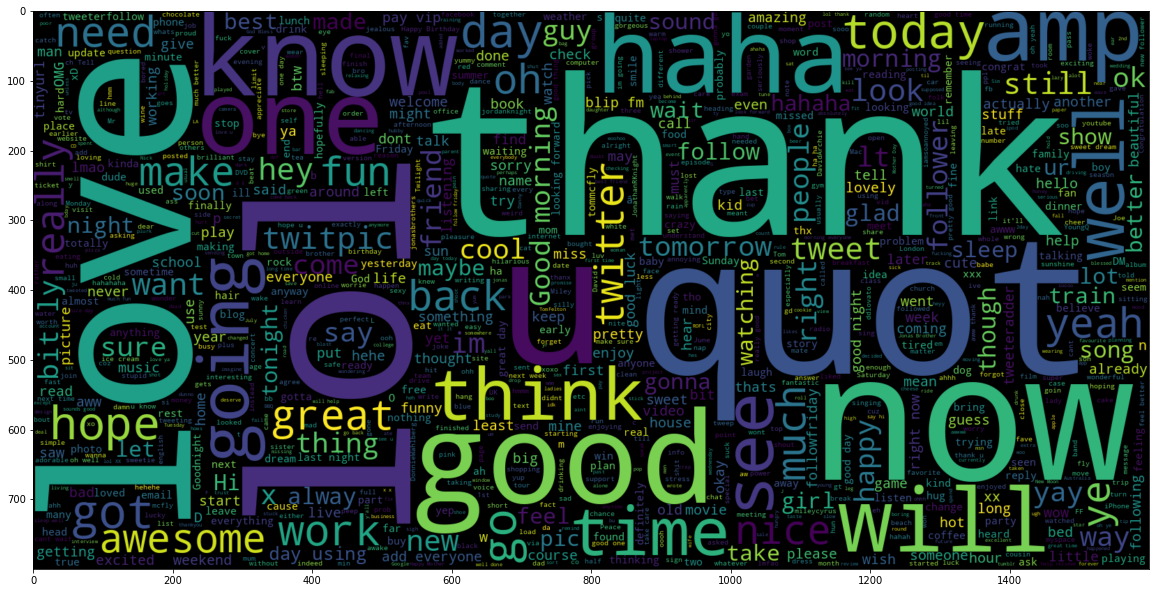

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(dev_dataset[dev_dataset.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('WordCloudPositive.svg', bbox_inches="tight")

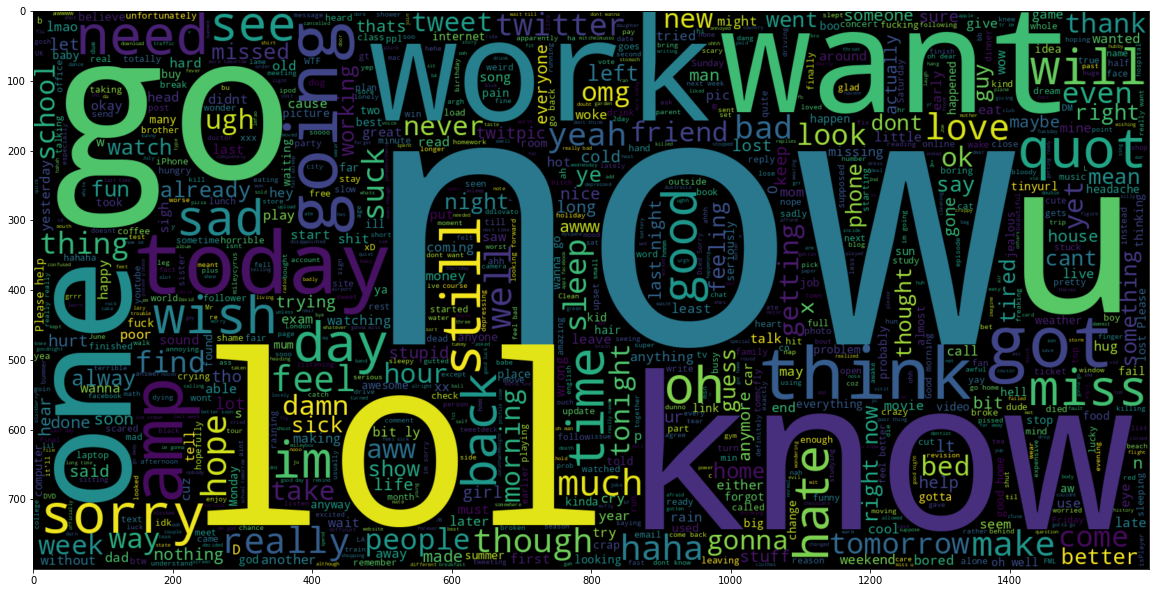

In [15]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(dev_dataset[dev_dataset.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('WordCloudNegative.svg', bbox_inches="tight")

### Train-test split

In [49]:
X = df_done.drop(columns=["sentiment"])
y = df_done["sentiment"]

X.shape, y.shape

((224994, 3), (224994,))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42, shuffle=True)

In [52]:
#da eliminare, copia di quello finale
##########################################################################################################

model = make_pipeline(
            make_column_transformer(
                (TfidfVectorizer(ngram_range= (1, 3)), "text"),
                (CountVectorizer(ngram_range= (1, 1), binary=True, strip_accents="unicode", stop_words='english'), "text_bis"),
                (OneHotEncoder(handle_unknown="ignore"), ["user"]),
                remainder="passthrough",
                n_jobs=-1
            ),
            #LogisticRegression(C = 1.25, max_iter = 1000, n_jobs=-1)
            LinearSVC(C = 0.125, max_iter = 1000)
    )
model.fit(X_train, y_train);

F1score = f1_score(y_test, model.predict(X_test), average='macro')
print(f"F1score : {F1score}")

F1score : 0.828239144722914


In [19]:
#da eliminare, copia di quello finale



# evaluation of the model and write to file
y_eval = model.predict(df_eval_done)
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("submit-final.csv", index_label="Id", header=["Predicted"])
print("File written....")
##########################################################################################################

File written....


### Pipeline
Try different model and select the best ones

In [20]:
tfidf_params = dict(#sublinear_tf= True, 
                    #use_idf = True,
                    #min_df = 2, 
                    #norm= 'l2', 
                    # token_pattern=r'\b[^\d\W]+\b', #remove number
                    # stop_words = 'english',
                    strip_accents="unicode",
                    ngram_range= (1, 3)
                    )

model = make_pipeline(
        make_column_transformer(
            (TfidfVectorizer(**tfidf_params), "text"),
            (CountVectorizer(ngram_range=(1, 1), binary=True, strip_accents="unicode", stop_words='english'), "text_bis"),
            (OneHotEncoder(handle_unknown="ignore"), ["user"]),
            remainder="passthrough",
            n_jobs=-1
        ),
        # MultinomialNB(alpha=0.3) #0.811 with alpha=0.3
        # DecisionTreeClassifier() #0.68
        # RandomForestClassifier(n_estimators=100, max_depth=30) #0.38
        # KNeighborsClassifier(algorithm = 'brute', n_jobs=-1) #0.70
        # SGDClassifier(max_iter=1000, tol=1e-3,  n_jobs=-1) #0.808
        # LogisticRegression(n_jobs=-1) # 0.8236
        LinearSVC() #0.821
    )
model.fit(X_train, y_train);

F1score = f1_score(y_test, model.predict(X_test), average='macro')
print(f"F1score : {F1score}")

F1score : 0.8211965704810589


In [21]:
# evaluation of the model and write to file
y_eval = model.predict(df_eval_done)
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("submit-final.csv", index_label="Id", header=["Predicted"])
print("File written....")

File written....


## Tuning hyperparameter - grid search 

Hyperparameter search for TfidfVectorizer and CountVectorizer ngram

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state=42, shuffle=True)

In [23]:
if flag_tuning:
    tfidf_range = [(1,1), (1,2), (1,3), (1,4), (1,5)]
    count_range = [(1,1), (1,2), (1,3), (1,4)]
    scores_ngram = np.zeros((5,4))


    for i in range(len(tfidf_range)):
        for ii in range(len(count_range)):
            model = make_pipeline(
                make_column_transformer(
                    (TfidfVectorizer(ngram_range=tfidf_range[i]), "text"),
                    (CountVectorizer(ngram_range=count_range[ii], binary=True, strip_accents="unicode", stop_words='english'), "text_bis"),
                    (OneHotEncoder(handle_unknown="ignore"), ["user"]),
                    remainder="passthrough",
                    n_jobs=-1

                ),
                #LogisticRegression(C = 1.25, max_iter = 1000, n_jobs=-1)
                LinearSVC(C = 0.125, max_iter = 1000)
            )

            model.fit(X_train, y_train);
            scores_ngram[i][ii] = f1_score(y_test, model.predict(X_test), average='macro')
            print(f"{tfidf_range[i]}, {count_range[ii]}: {scores_ngram[i][ii]}")

(1, 1), (1, 1): 0.8140990436641449
(1, 1), (1, 2): 0.8135116252262395
(1, 1), (1, 3): 0.8130600269414894
(1, 1), (1, 4): 0.8118206859745458
(1, 2), (1, 1): 0.8265045395134596
(1, 2), (1, 2): 0.8218016286955254
(1, 2), (1, 3): 0.8212511479876937
(1, 2), (1, 4): 0.8195056548544954
(1, 3), (1, 1): 0.8260939270981252
(1, 3), (1, 2): 0.820899956672327
(1, 3), (1, 3): 0.819740949707277
(1, 3), (1, 4): 0.8180313794143836
(1, 4), (1, 1): 0.8235935518925804
(1, 4), (1, 2): 0.8195163956491269
(1, 4), (1, 3): 0.8181285389801443
(1, 4), (1, 4): 0.8171261089340844
(1, 5), (1, 1): 0.8229041549423606
(1, 5), (1, 2): 0.8190729487380808
(1, 5), (1, 3): 0.8173985689464809
(1, 5), (1, 4): 0.8161554639501936


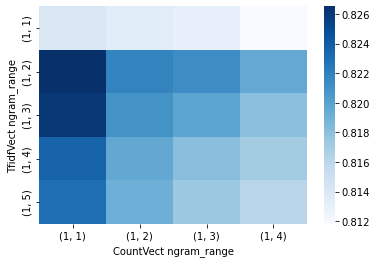

In [24]:
if flag_tuning:
    #plot scores_ngram heatmap
    ylbl = [(1,1), (1,2), (1,3), (1,4), (1,5)]
    xlbl = [(1,1), (1,2), (1,3), (1,4)]
    hyperparams = sns.heatmap(scores_ngram, cmap="Blues", xticklabels=xlbl, yticklabels=ylbl);
    hyperparams.set(xlabel="CountVect ngram_range", ylabel = "TfidfVect ngram_range");
    hyperparams.get_figure().savefig('hyperparams.svg', bbox_inches="tight")

Hyperparameter search for **Logistic regression**

link esempio: https://stackoverflow.com/questions/43366561/use-sklearns-gridsearchcv-with-a-pipeline-preprocessing-just-once

In [25]:
if flag_tuning:
    c_values = [0.1, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 7.0]
    scores_c_value = np.zeros((len(c_values), ))
    for i in range(len(c_values)):
        c_value = c_values[i]
        model = make_pipeline(
            make_column_transformer(
                (TfidfVectorizer(ngram_range=(1, 3)), "text"),
                (CountVectorizer(ngram_range=(1, 1), binary=True, strip_accents="unicode", stop_words='english'), "text_bis"),
                (OneHotEncoder(handle_unknown="ignore"), ["user"]),
                remainder="passthrough",
                n_jobs=-1
            ),
            LogisticRegression(C = c_value, max_iter = 1000, n_jobs=-1)
        )
        model.fit(X_train, y_train);
        scores_c_value[i] = f1_score(y_test, model.predict(X_test), average='macro')
        print(f"C value = {c_value}: {scores_c_value[i]}")

C value = 0.1: 0.7966133717928414
C value = 0.5: 0.821864605378231
C value = 1.0: 0.8244581497663082
C value = 1.25: 0.8248199145959099
C value = 1.5: 0.8247505995985027
C value = 1.75: 0.8249123263017785
C value = 2.0: 0.8245612063751726
C value = 3.0: 0.8249289743803738
C value = 5.0: 0.8246853263571716
C value = 7.0: 0.8237389174559742


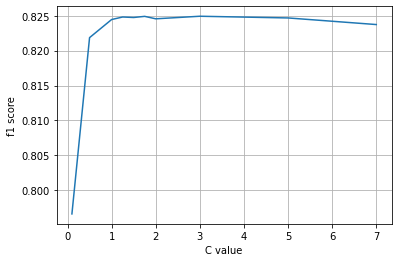

In [26]:
if flag_tuning:
    #plot C value graph - Logistic regression
    plt.grid(True)
    plt.xlabel("C value")
    plt.ylabel("f1 score")
    plt.plot(c_values, scores_c_value);
    plt.savefig('C_valueLogisticRegression.svg', bbox_inches="tight")

Hyperparameter search for **LinearSVC**

In [27]:
if flag_tuning:
    c_values = [0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.3, 0.4, 0.8, 1]
    scores_c_value = np.zeros((len(c_values), ))
    for i in range(len(c_values)):
        c_value = c_values[i]
        model = make_pipeline(
            make_column_transformer(
                (TfidfVectorizer(ngram_range=(1, 2)), "text"),
                (CountVectorizer(ngram_range=(1, 1), binary=True, strip_accents="unicode", stop_words='english'), "text_bis"),
                (OneHotEncoder(handle_unknown="ignore"), ["user"]),
                remainder="passthrough",
                n_jobs=-1
            ),
            LinearSVC(C = c_value, max_iter = 1000)
        )
        model.fit(X_train, y_train);
        scores_c_value[i] = f1_score(y_test, model.predict(X_test), average='macro')
        print(f"C value = {c_value}: {scores_c_value[i]}")

C value = 0.01: 0.7967938099081776
C value = 0.05: 0.8224158458032884
C value = 0.075: 0.8246975439153195
C value = 0.1: 0.8252824538572864
C value = 0.125: 0.8260939270981252
C value = 0.15: 0.8258537456857911
C value = 0.175: 0.8254574939703169
C value = 0.2: 0.8254385618820576
C value = 0.3: 0.8242752783167239
C value = 0.4: 0.8230170410165718
C value = 0.8: 0.8206595166086013
C value = 1: 0.8198627537852876


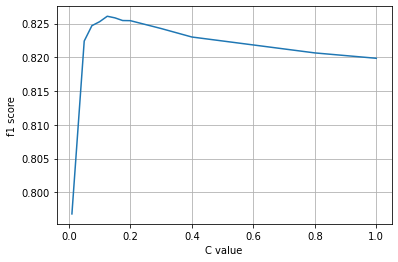

In [28]:
if flag_tuning:
    #plot C value graph - linearSVC regression
    plt.grid(True)
    plt.xlabel("C value")
    plt.ylabel("f1 score")
    plt.plot(c_values, scores_c_value);
    plt.savefig('C_valueLinearSVC.svg', bbox_inches="tight")

# Final  result

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state=42, shuffle=True)

In [54]:
model = make_pipeline(
            make_column_transformer(
                (TfidfVectorizer(ngram_range= (1, 2)), "text"),
                (CountVectorizer(ngram_range= (1, 1), binary=True, strip_accents="unicode", stop_words='english'), "text_bis"),
                (OneHotEncoder(handle_unknown="ignore"), ["user"]),
                remainder="passthrough",
                n_jobs=-1
            ),
        #LogisticRegression(C = 1.25, max_iter = 1000, n_jobs=-1)
        LinearSVC(C = 0.125, max_iter = 1000)
    )
model.fit(X_train, y_train);

F1score = f1_score(y_test, model.predict(X_test), average='macro')
print(f"F1score : {F1score}")

F1score : 0.828125210918129


In [30]:
# evaluation of the model and write to file
y_eval = model.predict(df_eval_done)
submit = pd.Series(y_eval, range(len(y_eval)))
submit.to_csv("submit-final.csv", index_label="Id", header=["Predicted"])
print("File written....")

File written....


### ROC curve

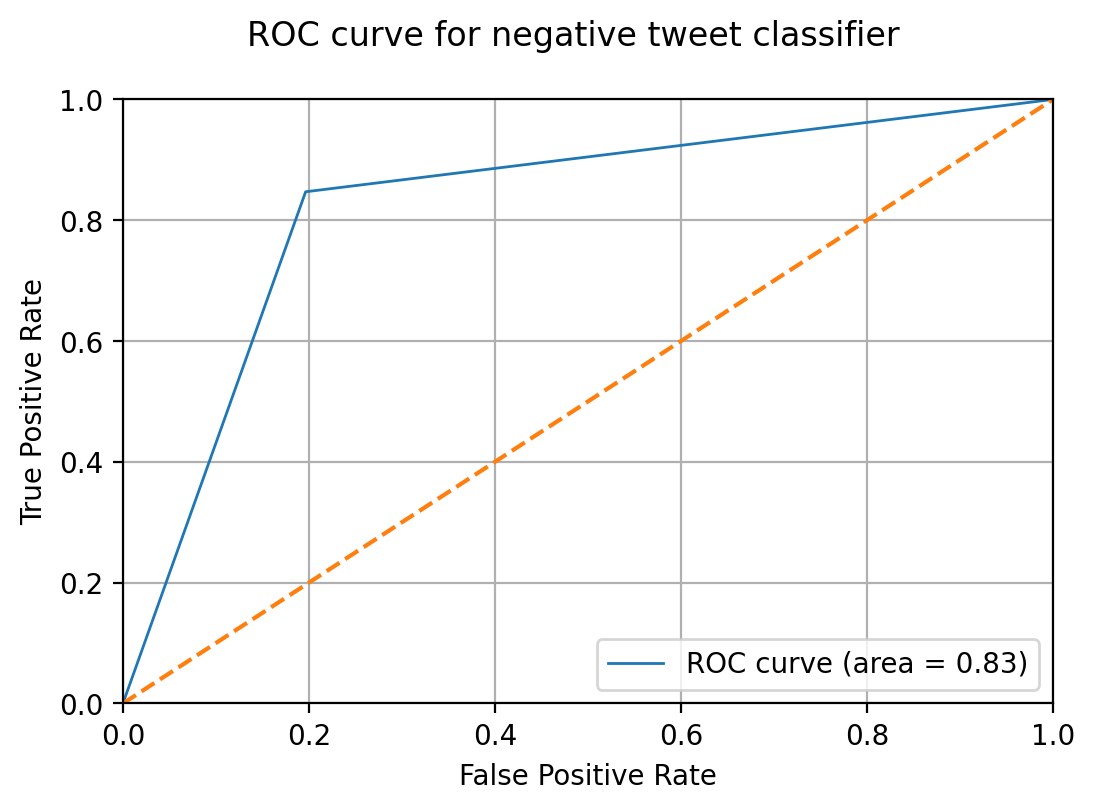

In [31]:
y_pred = model.predict(X_test) #[:,1]

# compute the false positive and true positive rate for the class 'neg'
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(dpi=200)
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
fig.suptitle('ROC curve for negative tweet classifier')
ax.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='dashed')
plt.savefig('Roc_curve.svg', bbox_inches="tight")

# Confusion matrix

[[19117  4674]
 [ 4961 27497]]




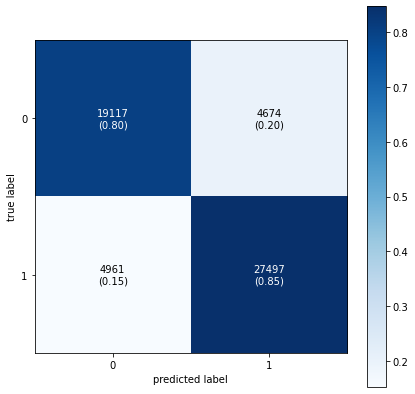

In [32]:
conf_matrix=confusion_matrix(y_test, y_pred)
print(conf_matrix)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=conf_matrix,figsize=(7, 7),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.savefig('ConfusionMatrix.svg', bbox_inches="tight")
plt.show()